<a href="https://colab.research.google.com/github/Soobian/deeplearning-project-f1/blob/leo/deep_learning_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

## Import modules

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input, RandomFlip, RandomRotation, RandomZoom, RandomContrast, RandomZoom, RandomBrightness, BatchNormalization
from tensorflow.keras import mixed_precision
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model

import matplotlib.pyplot as plt
import numpy as np

from google.colab import drive


## Import base models



In [2]:
from tensorflow.keras.applications import (
    EfficientNetB0, EfficientNetB1, EfficientNetB2
)

# Create dict that contains all EfficientNet models
models_dict = {
    "EfficientNetB0": (EfficientNetB0, (224, 224)),
    "EfficientNetB1": (EfficientNetB1, (240, 240)),
    "EfficientNetB2": (EfficientNetB2, (260, 260)),
}


## Mount Google Drive

In [3]:
# Path of datasets
train_dir = '/content/drive/MyDrive/Colab Notebooks/DatasetClassification/f1cars/train'
val_dir = '/content/drive/MyDrive/Colab Notebooks/DatasetClassification/f1cars/val'
test_dir = '/content/drive/MyDrive/Colab Notebooks/DatasetClassification/f1cars/test'
autosport_dataset_dir = '/content/drive/MyDrive/Colab Notebooks/DatasetClassification/f1cars/Autosport_Dataset'


In [4]:
# Connect to Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


# Set up data

## Data preparation for each model

In [21]:
# Get dataset from directory
def get_data_from_dir(dir, batch_size, input_size):
  data = keras.utils.image_dataset_from_directory(
        dir,
        labels="inferred",
        label_mode="categorical",
        color_mode="rgb",
        batch_size=batch_size,
        image_size=(input_size[0], input_size[1]),
        shuffle=True
    )

  return data

In [22]:
# Split data into training and validation sets
def split_dataset(dataset, split_ratio):
    # Get the size of the dataset and compute the split size depending on ratio
    dataset_size = int(tf.data.experimental.cardinality(dataset).numpy())
    train_split_size = int(dataset_size * split_ratio)

    # Split the dataset into training and validation
    split_train_data = dataset.take(train_split_size)
    split_val_data = dataset.skip(train_split_size)

    return split_train_data, split_val_data


In [23]:
def get_num_samples(data, mix_ratio):
  # Get total number of samples from data
  total_samples = tf.data.experimental.cardinality(data).numpy()

  # Calculate number of needed samples depending on mix_ratio
  num_samples_1 = int(total_samples * (1 - mix_ratio))
  num_samples_2 = int(total_samples * mix_ratio)

  return num_samples_1, num_samples_2


In [24]:
def mix_datasets(data_1, data_2, mix_ratio):
  # Get number of train samples depending on ratio
  # (1 - mix-ratio) defines number of samples of data_1
  # mix_ratio defines number of samples for data_2
  num_samples_1, num_samples_2 = get_num_samples(data_1, mix_ratio)

  # Mix datasets
  data_mixed = (
      data_1.take(num_samples_1)
      .concatenate(data_2.take(num_samples_2))
  )

  # Shuffle the mixed dataset
  data_mixed = data_mixed.shuffle(buffer_size=1000)

  return data_mixed


In [25]:
def get_autosport_data(autosport_dataset_dir, input_size):
  # Autosport data
  autosport_data = get_data_from_dir(autosport_dataset_dir,
                                      32,
                                      input_size)

  # Split autosport_data into training and validation parts
  # Default is 80% training and 20% validation data
  autosport_split_ratio=0.2
  autosport_train_data, autosport_val_data = split_dataset(autosport_data,
                                                            autosport_split_ratio)

  return autosport_train_data, autosport_val_data

In [26]:
# Get datasets and create a mixed dataset
def prepare_data(input_size, mix_ratio):
    # Training data
    train_data = get_data_from_dir(train_dir, 32, input_size)

    # Validation data
    val_data = get_data_from_dir(val_dir, 32, input_size)

    # Test data
    test_data = get_data_from_dir(test_dir, 32, input_size)

    # Autosport data
    autosport_train_data, autosport_val_data = get_autosport_data(autosport_dataset_dir, input_size)

    # Mix game and autosport training datasets
    # (1 - mix-ratio) defines number of samples of train_data
    # mix_ratio defines number of samples for autosport_train_data
    train_data_mixed = mix_datasets(train_data,
                                    autosport_train_data,
                                    mix_ratio)

    # Mix game and autosport validation datasets
    # (1 - mix-ratio) defines number of samples of val_data
    # mix_ratio defines number of samples for autosport_val_data
    val_data_mixed = mix_datasets(val_data,
                                  autosport_val_data,
                                  mix_ratio)

    # Prefetch to optimize performance
    train_data_mixed = train_data_mixed.prefetch(tf.data.AUTOTUNE)
    val_data_mixed = val_data_mixed.prefetch(tf.data.AUTOTUNE)
    test_data = test_data.prefetch(tf.data.AUTOTUNE)

    return train_data_mixed, val_data_mixed, test_data

In [27]:
# Initialize an empty dictionary to store prepared data for each model
data_dict = {}

# TODO: Try out model with different mixing ratios

# Iterate over each model in the models_dict dictionary
for model_name, model_info in models_dict.items():
    print(f"Preparing data for {model_name} with input size {model_info[1]}")

    # Call prepare_data function with the input size and mixing ratio
    train_data, val_data, test_data = prepare_data(model_info[1], 0.2)

    # Store the prepared data in the data_dict dictionary under the current model's name
    data_dict[model_name] = {
        "train_data": train_data,
        "val_data": val_data,
        "test_data": test_data,
    }

    print(f"Data prepared for {model_name}.")


Preparing data for EfficientNetB0 with input size (224, 224)
Found 6616 files belonging to 10 classes.
Found 2909 files belonging to 10 classes.
Found 1462 files belonging to 10 classes.
Found 1391 files belonging to 10 classes.
Data prepared for EfficientNetB0.
Preparing data for EfficientNetB1 with input size (240, 240)
Found 6616 files belonging to 10 classes.
Found 2909 files belonging to 10 classes.
Found 1462 files belonging to 10 classes.
Found 1391 files belonging to 10 classes.
Data prepared for EfficientNetB1.
Preparing data for EfficientNetB2 with input size (260, 260)
Found 6616 files belonging to 10 classes.
Found 2909 files belonging to 10 classes.
Found 1462 files belonging to 10 classes.
Found 1391 files belonging to 10 classes.
Data prepared for EfficientNetB2.


## Add augmentation to dataset

In [28]:
# Add randomization to dataset
data_augmentation = keras.Sequential(
    [
        RandomFlip("horizontal"),
        RandomRotation(0.3),
        RandomZoom(0.1),
        RandomContrast(0.3),
        RandomBrightness(0.1),
    ]
)

## Show dataset examples

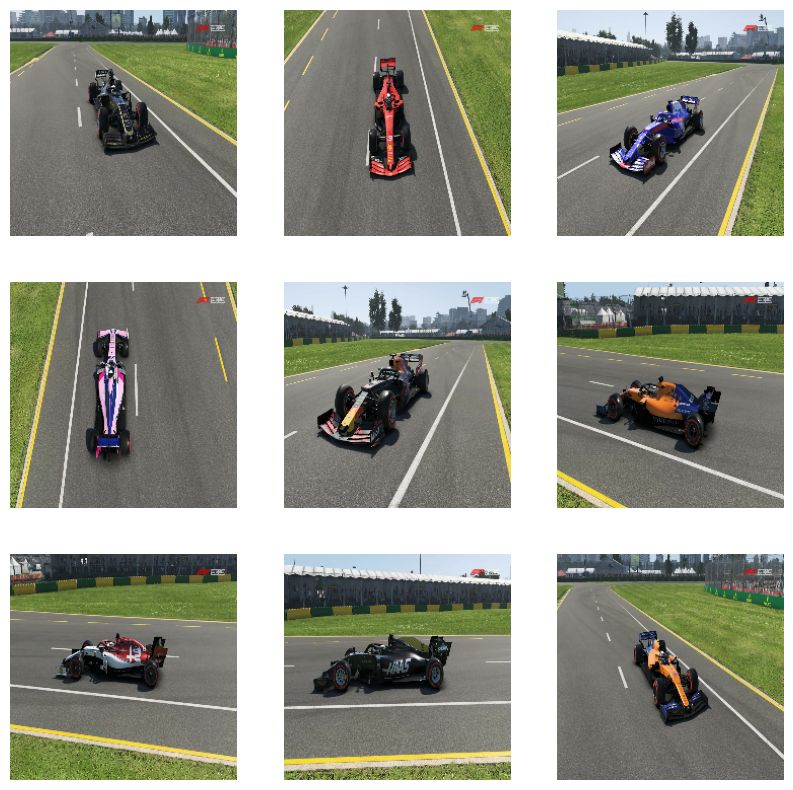

In [29]:
# Show image from dataset classes
plt.figure(figsize=(10, 10))
for images, labels in data_dict['EfficientNetB0']['train_data'].take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        pred_class = np.argmax(labels[i])
        plt.axis("off")

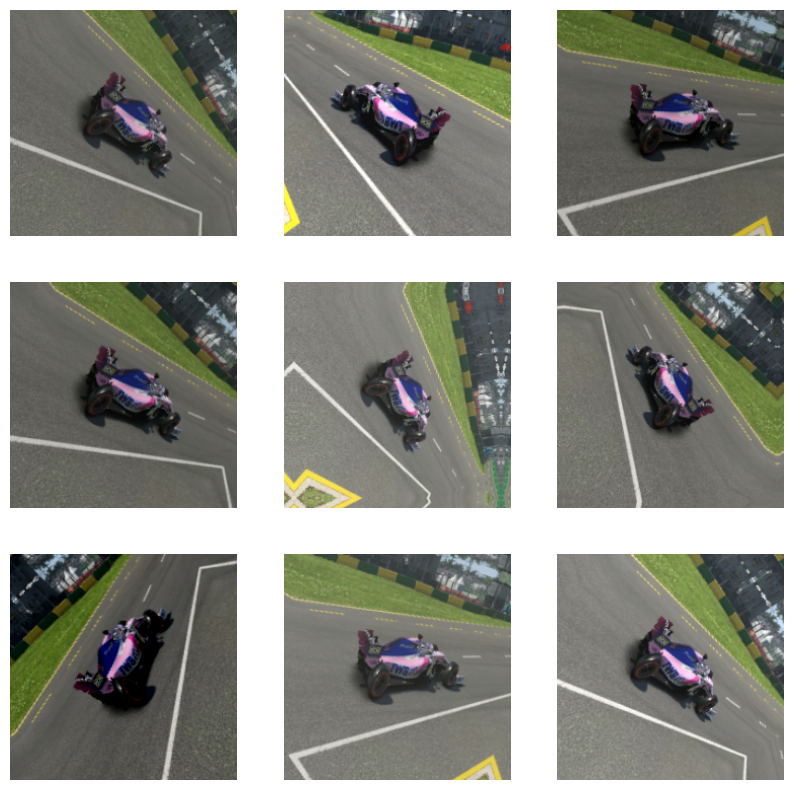

In [30]:
# Show randomized image from dataset classes
plt.figure(figsize=(10, 10))
for images, _ in data_dict['EfficientNetB0']['train_data'].take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")

# Creating the models

In [31]:
def create_model(base_model_class, input_size):
    input_layer = Input(shape=(input_size[0], input_size[1], 3), name="input_layer")
    base_model = base_model_class(include_top=False, weights='imagenet')

    # Freeze the base model's first 200 layers
    base_model.trainable = True
    for layer in base_model.layers[:200]:
      layer.trainable = False

    # Apply data augmentation to the input
    x = data_augmentation(input_layer)

    # Add base model
    x = base_model(x, training=False)
    x = GlobalAveragePooling2D()(x)

    x = BatchNormalization()(x)

    x = Dense(256, activation='relu')(x)
    x = Dropout(0.4)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)

    # Output layer with 10 classes
    output = Dense(10, activation='softmax', dtype=tf.float32)(x)

    # Create model
    model = keras.Model(inputs=input_layer, outputs=output)

    return model

In [32]:
model_instances = {}

for model_name, (model, input_size) in models_dict.items():
    # Create the model using the create_model function
    created_model = create_model(model, input_size)

    # Store the created model in the model_instances dictionary
    model_instances[model_name] = created_model

    print(f"Model created for {model_name} with input size {input_size}.")

Model created for EfficientNetB0 with input size (224, 224).
Model created for EfficientNetB1 with input size (240, 240).
Model created for EfficientNetB2 with input size (260, 260).


In [33]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0005,
    decay_steps=2000,
    decay_rate=0.96
)

# Training and testing models

## Plot the training data

In [34]:
# Plot the training and validation data
def plot_history(history, model_name):
  # Extract accuracy and loss from the history object
  train_acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  train_loss = history.history['loss']
  val_loss = history.history['val_loss']

  # Plot accuracy
  plt.figure(figsize=(12, 5))

  plt.subplot(1, 2, 1)
  plt.plot(train_acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  plt.title(f'{model_name} - Training and Validation Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

  # Plot loss
  plt.subplot(1, 2, 2)
  plt.plot(train_loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.title(f'{model_name} - Training and Validation Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

  plt.tight_layout()
  plt.show()

## Plot confusion matrix

In [ ]:
def  make_predictions(test_data):
  # Make predictions
  predictions = model.predict(test_data)

  # Convert predictions to class indices
  predicted_class_indices = np.argmax(predictions, axis=1)

  # Get true class labels from the test data
  true_class_indices = np.argmax(np.concatenate([y for x, y in test_data], axis=0), axis=1)

  return true_class_indices, predicted_class_indices

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(test_data):
  true_class_indices, predicted_class_indices = make_predictions(test_data)

  # Compute the confusion matrix
  cm = confusion_matrix(true_class_indices, predicted_class_indices)

  # ConfusionMatrixDisplay
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_class_names)
  disp.plot(cmap="Blues", xticks_rotation='vertical')
  plt.show()

  # Normalize by the sum of each row (true labels)
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

  # ConfusionMatrixDisplay with normalized values
  disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=test_class_names)
  disp.plot(cmap="Blues", xticks_rotation='vertical')
  plt.show()


## Train and evaluate model

In [35]:
# Compile, train, and evaluate a single model
def train_and_evaluate_model(model_name, model, data_dict):
    print(f"\nTraining: {model_name}\n")

    # Clear any previous session to free memory
    keras.backend.clear_session()

    # Compile the model
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    model.summary()

    # Train the model and capture the training history
    history = model.fit(
        data_dict[model_name]['train_data'],
        validation_data=data_dict[model_name]['val_data'],
        epochs=EPOCHS,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        callbacks=[early_stopping]
    )

    # Plot training history
    plot_history(history, model_name)

    # Evaluate model performance on test data
    test_loss, test_accuracy = model.evaluate(data_dict[model_name]['test_data'])

    # Plot the confusion matrix
    plot_confusion_matrix(data_dict[model_name]['test_data'])

    # Save the model with a timestamped filename
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    model_save_path = f"{MODEL_SAVE_PATH}{model_name}_model_{timestamp}.keras"
    model.save(model_save_path)

    # Store performance metrics
    performance_metrics[model_name] = {
        'Train Accuracy': history.history['accuracy'][-1],
        'Validation Accuracy': history.history['val_accuracy'][-1],
        'Test Accuracy': test_accuracy,
        'Train Loss': history.history['loss'][-1],
        'Validation Loss': history.history['val_loss'][-1],
        'Test Loss': test_loss
    }

    # Clean up memory after each model
    del model
    del history
    gc.collect()


Training: EfficientNetB0

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, None, None, 3)     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 batch_normalization (Batch  (None, 1280)              5120      
 Normalization)                                                  
                                  

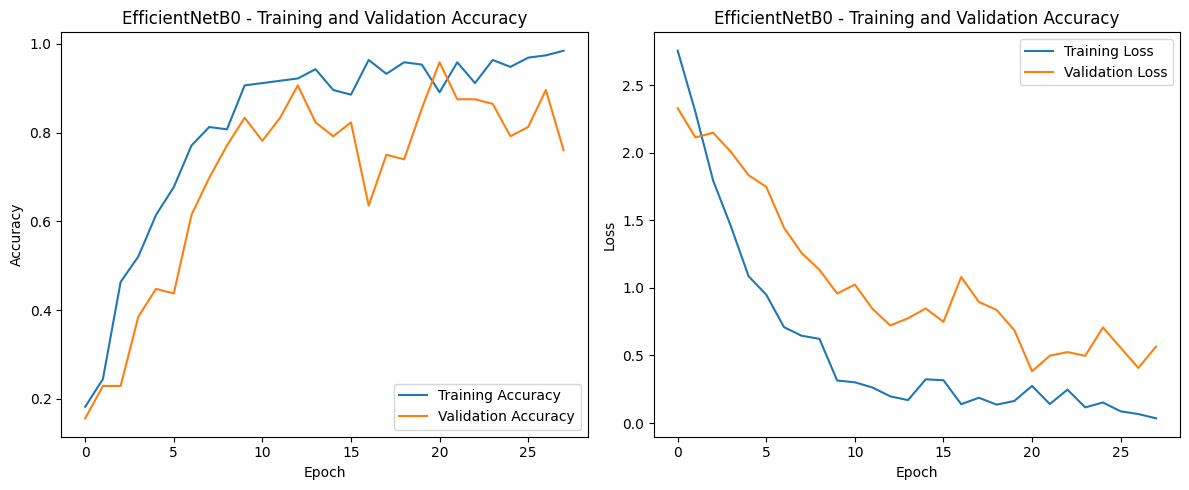

46/46 [==============================] - 17s 349ms/step - loss: 0.7620 - accuracy: 0.7483

Training: EfficientNetB1

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 240, 240, 3)]     0         
                                                                 
 sequential (Sequential)     (None, None, None, 3)     0         
                                                                 
 efficientnetb1 (Functional  (None, None, None, 1280   6575239   
 )                           )                                   
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 batch_normalization_1 (Bat  (None, 1280)              5120      
 chNorma

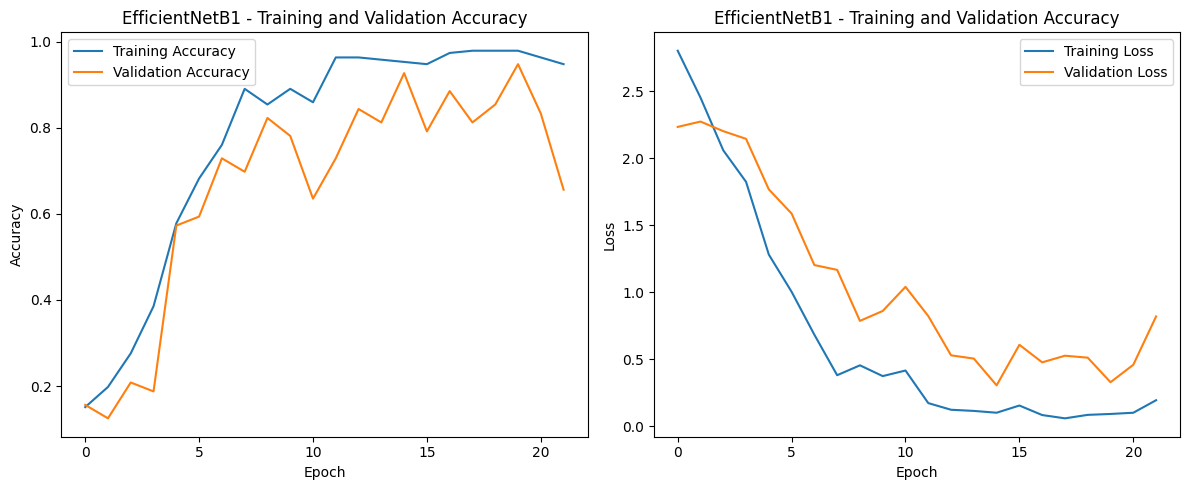

46/46 [==============================] - 24s 505ms/step - loss: 0.6172 - accuracy: 0.7962

Training: EfficientNetB2

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 260, 260, 3)]     0         
                                                                 
 sequential (Sequential)     (None, None, None, 3)     0         
                                                                 
 efficientnetb2 (Functional  (None, None, None, 1408   7768569   
 )                           )                                   
                                                                 
 global_average_pooling2d_2  (None, 1408)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 batch_normalization_2 (Bat  (None, 1408)              5632      
 chNorma

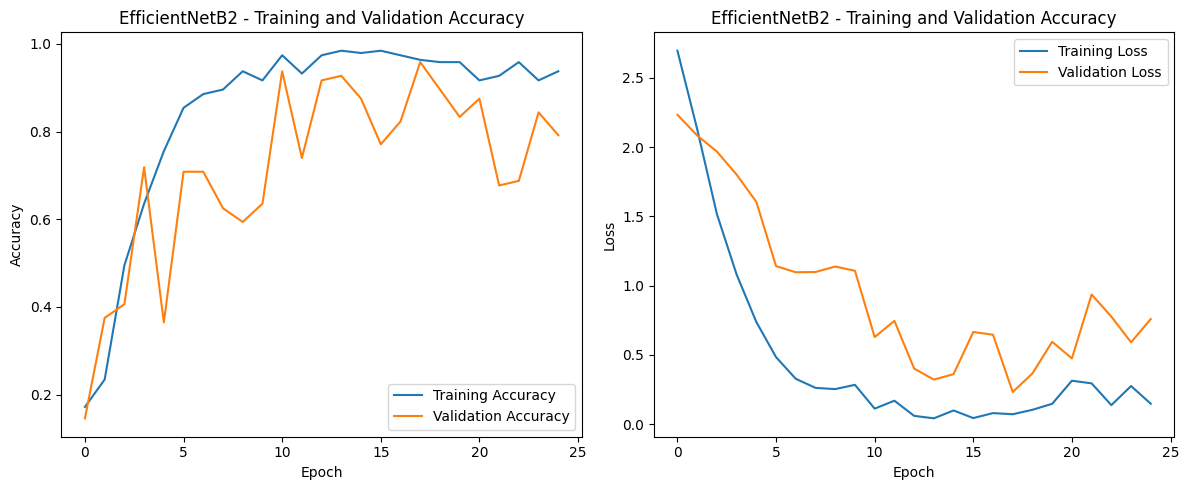

46/46 [==============================] - 31s 660ms/step - loss: 0.7794 - accuracy: 0.7469

Model: EfficientNetB0
Train Accuracy: 0.9844
Validation Accuracy: 0.7604
Test Accuracy: 0.7483
Train Loss: 0.0347
Validation Loss: 0.5657
Test Loss: 0.7620

Model: EfficientNetB1
Train Accuracy: 0.9479
Validation Accuracy: 0.6562
Test Accuracy: 0.7962
Train Loss: 0.1937
Validation Loss: 0.8192
Test Loss: 0.6172

Model: EfficientNetB2
Train Accuracy: 0.9375
Validation Accuracy: 0.7917
Test Accuracy: 0.7469
Train Loss: 0.1470
Validation Loss: 0.7586
Test Loss: 0.7794


In [36]:
import pandas as pd
import gc
from datetime import datetime

# Constants
BATCH_SIZE = 32
EPOCHS = 50
MODEL_SAVE_PATH = '/content/drive/MyDrive/Colab Notebooks/'

# Calculate steps per epoch
def calculate_steps(data, batch_size=BATCH_SIZE):
    return len(data) / batch_size

steps_per_epoch = calculate_steps(train_data)
validation_steps = calculate_steps(val_data)

# Dictionary to store performance metrics for each model
performance_metrics = {}

# Train and evaluate each model
for model_name, model in model_instances.items():
    train_and_evaluate_model(model_name, model, data_dict)

# Display performance metrics for each model
for model_name, metrics in performance_metrics.items():
    print(f"\nModel: {model_name}")
    for metric_name, value in metrics.items():
        print(f"{metric_name}: {value:.4f}")


# Testing the model on live footage

In [ ]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_data)

In [ ]:
# Make predictions
predictions = model.predict(test_data)

# Convert predictions to class indices
predicted_class_indices = np.argmax(predictions, axis=1)

# Get true class labels from the test data
true_class_indices = np.argmax(np.concatenate([y for x, y in test_data], axis=0), axis=1)

In [ ]:
# Print the accuracy and some predictions
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Display some example predictions
plt.figure(figsize=(10, 10))
for images, labels in test_data.take(10):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        pred_class = predicted_class_indices[i]
        true_class = np.argmax(labels[i])
        plt.title(f"Pred: {test_class_names[pred_class]}\nTrue: {test_class_names[true_class]}")
        plt.axis("off")

plt.show()

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute the confusion matrix
cm = confusion_matrix(true_class_indices, predicted_class_indices)

# ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_class_names)
disp.plot(cmap="Blues", xticks_rotation='vertical')
plt.show()

# Normalize by the sum of each row (true labels)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# ConfusionMatrixDisplay with normalized values
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=test_class_names)
disp.plot(cmap="Blues", xticks_rotation='vertical')
plt.show()


# Testing the model on photos from Autosport

In [ ]:
#Path to the test dataset
test_dir = '/content/drive/MyDrive/Colab Notebooks/DatasetClassification/f1cars/Autosport_Dataset'

# Load test data using image_dataset_from_directory, similar to train and validation data
test_data = keras.utils.image_dataset_from_directory(
    test_dir,
    labels="inferred",         # Labels are inferred from the directory structure
    label_mode="categorical",   # Same as in training
    color_mode="rgb",
    batch_size=32,
    image_size=(input_size[1], input_size[0]),
    shuffle=False              # No shuffling as this is for evaluation
)

test_class_names = test_data.class_names

In [ ]:
# Prefetch the data to optimize performance
test_data = test_data.prefetch(tf.data.AUTOTUNE)

for layer in model.layers:
    if hasattr(layer, 'training'):
        layer.training = False

In [ ]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_data)

In [ ]:
# Make predictions
predictions = model.predict(test_data)

# Convert predictions to class indices
predicted_class_indices = np.argmax(predictions, axis=1)

# Get true class labels from the test data
true_class_indices = np.argmax(np.concatenate([y for x, y in test_data], axis=0), axis=1)

In [ ]:
# Print the accuracy and some predictions
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Display some example predictions
plt.figure(figsize=(10, 10))
for images, labels in test_data.take(10):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        pred_class = predicted_class_indices[i]
        true_class = np.argmax(labels[i])
        plt.title(f"Pred: {test_class_names[pred_class]}\nTrue: {test_class_names[true_class]}")
        plt.axis("off")

plt.show()

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute the confusion matrix
cm = confusion_matrix(true_class_indices, predicted_class_indices)

# ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_class_names)
disp.plot(cmap="Blues", xticks_rotation='vertical')
plt.show()

# Normalize by the sum of each row (true labels)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# ConfusionMatrixDisplay with normalized values
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=test_class_names)
disp.plot(cmap="Blues", xticks_rotation='vertical')
plt.show()
